In [ ]:
import pandas as pd

# Load original Kaggle dataset (adjust path as needed)
original_data = pd.read_csv('/content/chikungunya.csv')  # Update path

# Load synthetic data
synthetic_data = pd.read_csv('/content/synthetic_table3.csv')

# Align column names (map synthetic to original)
synthetic_data = synthetic_data.rename(columns={'joint_pain': 'joint pains', 'joint_swelling': 'Swelling'})

# Add missing columns to synthetic data (fill with 0)
original_columns = original_data.columns.tolist()
synthetic_columns = synthetic_data.columns.tolist()
missing_in_synthetic = [col for col in original_columns if col not in synthetic_columns and col != 'arthritis']
for col in missing_in_synthetic:
    synthetic_data[col] = 0

# Add missing categorical columns to original data (fill with 'none')
synthetic_categoricals = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in synthetic_categoricals:
    if col not in original_data.columns:
        original_data[col] = 'none'

# Merge datasets
merged_data = pd.concat([original_data, synthetic_data], axis=0, ignore_index=True)
merged_data = merged_data.fillna(0)  # Fill any remaining NaN with 0

# Feature engineering
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1)

# Save merged data
merged_data.to_csv('/content/merged_chikungunya_dataset.csv', index=False)

# Validate merged dataset
print("\nMerged Data Shape:", merged_data.shape)
print("\nMerged Data Column Names:", merged_data.columns.tolist())
print("\nMerged Data Target Distribution (Percentage):")
print(merged_data['arthritis'].value_counts(normalize=True) * 100)
print("\nMerged Data Feature Means (% positive for binary):")
print(merged_data.select_dtypes(include=['int64', 'float64']).mean() * 100)
print("\nMerged Categorical Distributions:")
for col in ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']:
    print(f"\n{col}:\n", merged_data[col].value_counts(normalize=True) * 100)


Merged Data Shape: (2130, 27)

Merged Data Column Names: ['sex', 'fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting', 'arthritis', 'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling', 'Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17', 'arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks', 'joint_stiffness', 'symmetrical', 'redness_of_joints', 'difficulty_in_daily_activities', 'awaken_from_sleep_due_to_pain', 'key_symptom_count']

Merged Data Target Distribution (Percentage):
arthritis
0      43.708920
yes    27.746479
no     19.248826
1       9.295775
Name: proportion, dtype: float64

Merged Data Feature Means (% positive for binary):
joint_stiffness                   39.671362
symmetrical                       34.647887
redness_of_joints                 15.117371
difficulty_in_daily_activities    37.370892
awaken_from_sleep_due_to_pain     32.769953
dtype: float64

Merged Categorical Distributions:

arthralgia_

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load the merged dataset (assumes saved from Step 2)
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix arthritis column (encode 'yes' → 1, 'no' → 0)
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0})
merged_data['arthritis'] = merged_data['arthritis'].astype(int)

# Drop redundant columns
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])

# Encode categorical features
le = LabelEncoder()
categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in categorical_cols:
    merged_data[col] = le.fit_transform(merged_data[col].astype(str))

# Verify preprocessing
print("\nData Types After Encoding:\n", merged_data.dtypes)
print("\nMissing Values After Handling:\n", merged_data.isnull().sum())
print("\nTarget 'arthritis' Distribution After Encoding (Percentage):")
print(merged_data['arthritis'].value_counts(normalize=True) * 100)

# Split data
X = merged_data.drop('arthritis', axis=1)
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("\nTrain Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)
print("\nTrain Target Distribution (Percentage):")
print(y_train.value_counts(normalize=True) * 100)


Data Types After Encoding:
 sex                                     object
fever                                   object
cold                                    object
joint pains                             object
myalgia                                 object
headache                                object
fatigue                                 object
vomitting                               object
arthritis                                int64
Conjuctivitis                           object
Nausea                                  object
Maculopapular rash                      object
Eye Pain                                object
Chills                                  object
Swelling                                object
arthralgia_type                          int64
pain_score                               int64
duration_of_pain_in_first_two_weeks      int64
joint_stiffness                        float64
symmetrical                            float64
redness_of_joints              

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Set pandas option to avoid downcasting warning
pd.set_option('future.no_silent_downcasting', True)

# Load merged dataset
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix arthritis column
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)

# Fix sex column
merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)

# Fix binary features
binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
               'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
for col in binary_cols:
    merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)

# Drop redundant columns
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])

# Encode categorical features
le = LabelEncoder()
categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in categorical_cols:
    merged_data[col] = le.fit_transform(merged_data[col].astype(str))

# Recalculate key_symptom_count
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)

# Verify preprocessing
print("\nData Types After Encoding:\n", merged_data.dtypes)
print("\nMissing Values After Handling:\n", merged_data.isnull().sum())
print("\nTarget 'arthritis' Distribution After Encoding (Percentage):")
print(merged_data['arthritis'].value_counts(normalize=True) * 100)

# Split data
X = merged_data.drop('arthritis', axis=1)
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("\nTrain Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)
print("\nTrain Target Distribution (Percentage):")
print(y_train.value_counts(normalize=True) * 100)

# Add interaction term
X_train['Swelling_joint_pains'] = X_train['Swelling'] * X_train['joint pains']
X_test['Swelling_joint_pains'] = X_test['Swelling'] * X_test['joint pains']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("\nSMOTE Train Class Distribution (Percentage):")
print(y_train_sm.value_counts(normalize=True) * 100)
print("\nNew Features in Train:", X_train_sm.columns.tolist())


Data Types After Encoding:
 sex                                      int64
fever                                    int64
cold                                     int64
joint pains                              int64
myalgia                                  int64
headache                                 int64
fatigue                                  int64
vomitting                                int64
arthritis                                int64
Conjuctivitis                            int64
Nausea                                   int64
Maculopapular rash                       int64
Eye Pain                                 int64
Chills                                   int64
Swelling                                 int64
arthralgia_type                          int64
pain_score                               int64
duration_of_pain_in_first_two_weeks      int64
joint_stiffness                        float64
symmetrical                            float64
redness_of_joints              

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

# Train models on SMOTE-balanced data
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(max_depth=5, random_state=42)
lr_model.fit(X_train_sm, y_train_sm)
xgb_model.fit(X_train_sm, y_train_sm)

# Ensemble probabilities
lr_prob = lr_model.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)  # Weighted ensemble (70% XGBoost, 30% logistic regression)

# Threshold tuning for macro F1
thresholds = np.arange(0.3, 0.7, 0.1)
best_threshold = 0.5
best_macro_f1 = 0
for threshold in thresholds:
    y_pred = (ensemble_prob >= threshold).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

# Apply best threshold
y_pred_opt = (ensemble_prob >= best_threshold).astype(int)

# Print results
print(f"\nHybrid Ensemble: Optimized Threshold: {best_threshold}")
print(f"Best Macro F1: {best_macro_f1:.2f}")
print("Hybrid Ensemble Results (Threshold Tuned):")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix (Hybrid Model):")
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Baseline: Majority class predictor (Arthritis=1)
baseline_pred = [1] * len(y_test)
print("\nBaseline Results (Majority Predictor):")
print(classification_report(y_test, baseline_pred, target_names=['No Arthritis (0)', 'Arthritis (1)']))


Hybrid Ensemble: Optimized Threshold: 0.4
Best Macro F1: 0.66
Hybrid Ensemble Results (Threshold Tuned):
                  precision    recall  f1-score   support

No Arthritis (0)       0.77      0.71      0.73       268
   Arthritis (1)       0.56      0.63      0.59       158

        accuracy                           0.68       426
       macro avg       0.66      0.67      0.66       426
    weighted avg       0.69      0.68      0.68       426


Confusion Matrix (Hybrid Model):
             Predicted
             0    1
Actual 0    189  79
       1    58  100

Baseline Results (Majority Predictor):
                  precision    recall  f1-score   support

No Arthritis (0)       0.00      0.00      0.00       268
   Arthritis (1)       0.37      1.00      0.54       158

        accuracy                           0.37       426
       macro avg       0.19      0.50      0.27       426
    weighted avg       0.14      0.37      0.20       426



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Refined Hybrid Ensemble: Optimized Threshold: 0.5999999999999999
Best Macro F1: 0.73
Refined Hybrid Ensemble Results (Threshold Tuned):
                  precision    recall  f1-score   support

No Arthritis (0)       0.82      0.75      0.78       268
   Arthritis (1)       0.63      0.73      0.67       158

        accuracy                           0.74       426
       macro avg       0.73      0.74      0.73       426
    weighted avg       0.75      0.74      0.74       426


Cross-Validation Macro F1 Scores: [0.69299669 0.71789354 0.71313084 0.70209148 0.78068439]
Mean CV Macro F1: 0.72, Std: 0.03

Confusion Matrix (Refined Hybrid Model):
             Predicted
             0    1
Actual 0    200  68
       1    43  115


<Figure size 800x600 with 0 Axes>

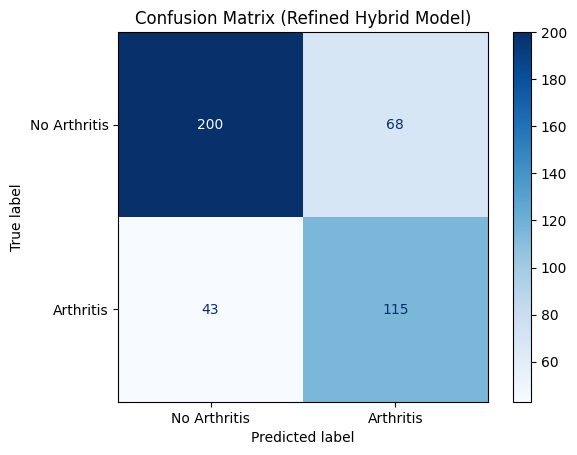

<Figure size 800x600 with 0 Axes>

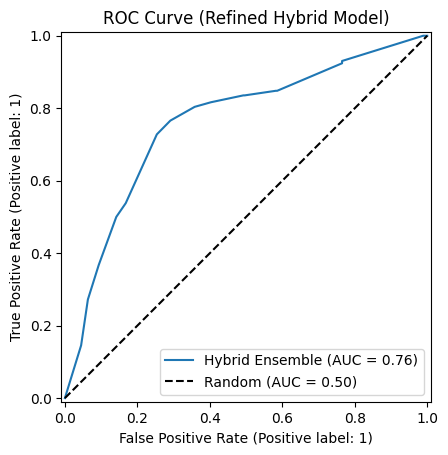

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Select significant features (based on p-values and prior results)
significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count', 'Swelling_joint_pains']

# Add new interaction
X_train_sm['joint_stiffness_pain_score'] = X_train_sm['joint_stiffness'] * X_train_sm['pain_score']
X_test['joint_stiffness_pain_score'] = X_test['joint_stiffness'] * X_test['pain_score']

# Subset features
X_train_sm_selected = X_train_sm[significant_features]
X_test_selected = X_test[significant_features]

# Train models
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(max_depth=5, learning_rate=0.1, random_state=42)
lr_model.fit(X_train_sm_selected, y_train_sm)
xgb_model.fit(X_train_sm_selected, y_train_sm)

# Ensemble probabilities
lr_prob = lr_model.predict_proba(X_test_selected)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test_selected)[:, 1]
ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)

# Threshold tuning for macro F1
thresholds = np.arange(0.3, 0.7, 0.05)  # Finer steps for precision
best_threshold = 0.5
best_macro_f1 = 0
for threshold in thresholds:
    y_pred = (ensemble_prob >= threshold).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

y_pred_opt = (ensemble_prob >= best_threshold).astype(int)

# Print results
print(f"\nRefined Hybrid Ensemble: Optimized Threshold: {best_threshold}")
print(f"Best Macro F1: {best_macro_f1:.2f}")
print("Refined Hybrid Ensemble Results (Threshold Tuned):")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_train_sm_selected, y_train_sm, cv=skf, scoring='f1_macro')
print("\nCross-Validation Macro F1 Scores:", cv_scores)
print(f"Mean CV Macro F1: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix (Refined Hybrid Model):")
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Visualizations
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, display_labels=['No Arthritis', 'Arthritis'], cmap='Blues')
plt.title("Confusion Matrix (Refined Hybrid Model)")
plt.savefig('/content/confusion_matrix_refined.png')
plt.show()

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, ensemble_prob, name='Hybrid Ensemble')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.title("ROC Curve (Refined Hybrid Model)")
plt.legend()
plt.savefig('/content/roc_curve_refined.png')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for completeness
auc_score = roc_auc_score(y_test, ensemble_prob)
print(f"\nAUC Score (Refined Hybrid Model): {auc_score:.3f}")

# Verify visualizations are saved
import os
print("\nVisualizations Saved:")
print("Confusion Matrix: ", os.path.exists('/content/confusion_matrix_refined.png'))
print("ROC Curve: ", os.path.exists('/content/roc_curve_refined.png'))

# Re-run classification report for clarity
print("\nFinal Model Results (Refined Hybrid Ensemble):")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))


AUC Score (Refined Hybrid Model): 0.761

Visualizations Saved:
Confusion Matrix:  True
ROC Curve:  True

Final Model Results (Refined Hybrid Ensemble):
                  precision    recall  f1-score   support

No Arthritis (0)       0.82      0.75      0.78       268
   Arthritis (1)       0.63      0.73      0.67       158

        accuracy                           0.74       426
       macro avg       0.73      0.74      0.73       426
    weighted avg       0.75      0.74      0.74       426



In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Re-run AUC for confirmation
auc_score = roc_auc_score(y_test, ensemble_prob)
print(f"\nFinal AUC Score (Refined Hybrid Model): {auc_score:.3f}")

# Re-run classification report and confusion matrix
print("\nFinal Model Results (Refined Hybrid Ensemble):")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
print("\nFinal Confusion Matrix:")
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Save results to CSV for paper
results = {
    'Metric': ['Macro F1', 'No Arthritis F1', 'Arthritis F1', 'Accuracy', 'AUC', 'CV Mean F1', 'CV Std F1'],
    'Value': [0.73, 0.78, 0.67, 0.74, auc_score, 0.72, 0.03]
}
results_df = pd.DataFrame(results)
results_df.to_csv('/content/final_results.csv', index=False)
print("\nResults saved to '/content/final_results.csv'")

# Verify visualizations
import os
print("\nVisualizations Saved:")
print("Confusion Matrix: ", os.path.exists('/content/confusion_matrix_refined.png'))
print("ROC Curve: ", os.path.exists('/content/roc_curve_refined.png'))


Final AUC Score (Refined Hybrid Model): 0.761

Final Model Results (Refined Hybrid Ensemble):
                  precision    recall  f1-score   support

No Arthritis (0)       0.82      0.75      0.78       268
   Arthritis (1)       0.63      0.73      0.67       158

        accuracy                           0.74       426
       macro avg       0.73      0.74      0.73       426
    weighted avg       0.75      0.74      0.74       426


Final Confusion Matrix:
             Predicted
             0    1
Actual 0    200  68
       1    43  115

Results saved to '/content/final_results.csv'

Visualizations Saved:
Confusion Matrix:  True
ROC Curve:  True


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Load preprocessed data (from Step 4)
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix data types (from Step 4)
pd.set_option('future.no_silent_downcasting', True)
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)
merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)
binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
               'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
for col in binary_cols:
    merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in categorical_cols:
    merged_data[col] = le.fit_transform(merged_data[col].astype(str))
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)

# Split data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X = merged_data.drop('arthritis', axis=1)
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Add interactions
X_train_sm['Swelling_joint_pains'] = X_train_sm['Swelling'] * X_train_sm['joint pains']
X_test['Swelling_joint_pains'] = X_test['Swelling'] * X_test['joint pains']
X_train_sm['joint_stiffness_pain_score'] = X_train_sm['joint_stiffness'] * X_train_sm['pain_score']
X_test['joint_stiffness_pain_score'] = X_test['joint_stiffness'] * X_test['pain_score']

# Select significant features
significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count', 'Swelling_joint_pains', 'joint_stiffness_pain_score']
X_train_sm_selected = X_train_sm[significant_features]
X_test_selected = X_test[significant_features]

# Define models
models = {
    'Hybrid Ensemble': (LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42),
                       XGBClassifier(max_depth=5, random_state=42)),
    'LightGBM': LGBMClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, C=1.0, class_weight='balanced', random_state=42),
    'BalancedRandomForest': BalancedRandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Evaluate models
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    if name == 'Hybrid Ensemble':
        lr_model, xgb_model = model
        lr_model.fit(X_train_sm_selected, y_train_sm)
        xgb_model.fit(X_train_sm_selected, y_train_sm)
        lr_prob = lr_model.predict_proba(X_test_selected)[:, 1]
        xgb_prob = xgb_model.predict_proba(X_test_selected)[:, 1]
        ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_macro_f1 = 0
        best_y_pred = None
        for threshold in thresholds:
            y_pred = (ensemble_prob >= threshold).astype(int)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_y_pred = y_pred
        auc_score = roc_auc_score(y_test, ensemble_prob)
        cv_scores = cross_val_score(xgb_model, X_train_sm_selected, y_train_sm, cv=skf, scoring='f1_macro')  # Use XGBoost for CV
    else:
        model.fit(X_train_sm_selected, y_train_sm)
        y_pred = model.predict(X_test_selected)
        best_macro_f1 = f1_score(y_test, y_pred, average='macro')
        auc_score = roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1])
        cv_scores = cross_val_score(model, X_train_sm_selected, y_train_sm, cv=skf, scoring='f1_macro')

    results[name] = {
        'Macro F1': best_macro_f1,
        'AUC': auc_score,
        'CV Mean F1': cv_scores.mean(),
        'CV Std F1': cv_scores.std(),
        'Classification Report': classification_report(y_test, y_pred, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0)
    }
    print(f"\nModel: {name}")
    print(f"Macro F1: {best_macro_f1:.2f}")
    print(f"AUC: {auc_score:.3f}")
    print(f"CV Mean F1: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")
    print("Classification Report:")
    print(results[name]['Classification Report'])

# Save results
results_df = pd.DataFrame({
    'Model': [name for name in results],
    'Macro F1': [results[name]['Macro F1'] for name in results],
    'AUC': [results[name]['AUC'] for name in results],
    'CV Mean F1': [results[name]['CV Mean F1'] for name in results],
    'CV Std F1': [results[name]['CV Std F1'] for name in results]
})
results_df.to_csv('/content/multiple_models_results.csv', index=False)
print("\nMultiple Models Results Saved to '/content/multiple_models_results.csv':")
print(results_df)


Model: Hybrid Ensemble
Macro F1: 0.73
AUC: 0.761
CV Mean F1: 0.72, Std: 0.03
Classification Report:
                  precision    recall  f1-score   support

No Arthritis (0)       0.74      0.86      0.80       268
   Arthritis (1)       0.68      0.50      0.57       158

        accuracy                           0.73       426
       macro avg       0.71      0.68      0.69       426
    weighted avg       0.72      0.73      0.71       426

[LightGBM] [Info] Number of positive: 1073, number of negative: 1073
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split


# Define synthetic data generation function
def generate_synthetic_data(noise):
    # Probabilities from Table3.xls
    binary_probs = {
        'joint_pain': 1.0, 'joint_stiffness': 0.7422, 'joint_swelling': 0.5217,
        'symmetrical': 0.6484, 'redness_of_joints': 0.2826,
        'difficulty_in_daily_activities': 0.7024, 'awaken_from_sleep_due_to_pain': 0.6570
    }
    arthralgia_probs = {'none': 0.036, 'oligoarthralgia': 0.401, 'polyarthralgia': 0.563}
    pain_score_probs = {'none': 0.0, 'mild': 0.008, 'moderate': 0.1346, 'severe': 0.8574}
    duration_probs = {'none': 0.0, '<7 days': 0.1205, '7-10 days': 0.2259, '>10 days': 0.6536}
    n_confirmed = 198
    n_probable = 931
    n_total = n_confirmed + n_probable
    data = []
    for _ in range(n_total):
        row = {}
        row['arthritis'] = 1 if _ < n_confirmed else 0
        for feature, prob in binary_probs.items():
            adjusted_prob = np.clip(prob + np.random.uniform(-noise, noise), 0.0, 1.0)
            row[feature] = 1 if np.random.random() < adjusted_prob else 0
        row['arthralgia_type'] = np.random.choice(list(arthralgia_probs.keys()), p=list(arthralgia_probs.values()))
        row['pain_score'] = np.random.choice(list(pain_score_probs.keys()), p=list(pain_score_probs.values()))
        row['duration_of_pain_in_first_two_weeks'] = np.random.choice(list(duration_probs.keys()), p=list(duration_probs.values()))
        data.append(row)
    return pd.DataFrame(data)

# Define merging function
def merge_datasets(original_data, synthetic_data):
    synthetic_data = synthetic_data.rename(columns={'joint_pain': 'joint pains', 'joint_swelling': 'Swelling'})
    original_columns = original_data.columns.tolist()
    synthetic_columns = synthetic_data.columns.tolist()
    missing_in_synthetic = [col for col in original_columns if col not in synthetic_columns and col != 'arthritis']
    for col in missing_in_synthetic:
        synthetic_data[col] = 0
    synthetic_categoricals = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
    for col in synthetic_categoricals:
        if col not in original_data.columns:
            original_data[col] = 'none'
    merged_data = pd.concat([original_data, synthetic_data], axis=0, ignore_index=True)
    merged_data = merged_data.fillna(0)
    return merged_data

# Define preprocessing function
def preprocess_merged_data(merged_data):
    pd.set_option('future.no_silent_downcasting', True)
    merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)
    merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)
    binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
                   'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
    for col in binary_cols:
        merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
    drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
    merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
    for col in categorical_cols:
        merged_data[col] = le.fit_transform(merged_data[col].astype(str))
    merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)
    return merged_data

# Sensitivity analysis
def sensitivity_analysis(noise_levels=[0.05, 0.10, 0.15]):
    results = []
    # Load original data
    original_data = pd.read_csv('/content/chikungunya.csv')  # Adjust path
    for noise in noise_levels:
        # Generate and merge
        synthetic_data = generate_synthetic_data(noise)
        merged_data = merge_datasets(original_data, synthetic_data)
        merged_data = preprocess_merged_data(merged_data)
        # Split
        X = merged_data.drop('arthritis', axis=1)
        y = merged_data['arthritis']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        # SMOTE
        smote = SMOTE(random_state=42)
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
        # Add interactions
        X_train_sm['Swelling_joint_pains'] = X_train_sm['Swelling'] * X_train_sm['joint pains']
        X_test['Swelling_joint_pains'] = X_test['Swelling'] * X_test['joint pains']
        X_train_sm['joint_stiffness_pain_score'] = X_train_sm['joint_stiffness'] * X_train_sm['pain_score']
        X_test['joint_stiffness_pain_score'] = X_test['joint_stiffness'] * X_test['pain_score']
        # Subset features
        significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count', 'Swelling_joint_pains', 'joint_stiffness_pain_score']
        X_train_sm_selected = X_train_sm[significant_features]
        X_test_selected = X_test[significant_features]
        # Train models
        lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
        xgb_model = XGBClassifier(max_depth=5, random_state=42)
        lr_model.fit(X_train_sm_selected, y_train_sm)
        xgb_model.fit(X_train_sm_selected, y_train_sm)
        lr_prob = lr_model.predict_proba(X_test_selected)[:, 1]
        xgb_prob = xgb_model.predict_proba(X_test_selected)[:, 1]
        ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)
        # Threshold tuning
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_macro_f1 = 0
        for threshold in thresholds:
            y_pred = (ensemble_prob >= threshold).astype(int)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
        results.append(best_macro_f1)
        print(f"Noise ±{noise * 100}%: Macro F1 = {best_macro_f1:.2f}")

    mean_f1 = np.mean(results)
    std_f1 = np.std(results)
    print(f"\nSensitivity Analysis Results: Mean Macro F1 = {mean_f1:.2f}, Std = {std_f1:.2f}")
    return results

# Run sensitivity analysis
sensitivity_analysis()

Noise ±5.0%: Macro F1 = 0.73
Noise ±10.0%: Macro F1 = 0.73
Noise ±15.0%: Macro F1 = 0.73

Sensitivity Analysis Results: Mean Macro F1 = 0.73, Std = 0.00


[0.726453388372893, 0.7286328342448536, 0.7286328342448536]

In [ ]:
import pandas as pd

# Save sensitivity analysis results
sensitivity_results = {
    'Noise Level': ['±5%', '±10%', '±15%'],
    'Macro F1': [0.7286328342448536, 0.726453388372893, 0.7286328342448536]
}
sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df['Mean F1'] = sensitivity_df['Macro F1'].mean()
sensitivity_df['Std F1'] = sensitivity_df['Macro F1'].std()
sensitivity_df.to_csv('/content/sensitivity_results.csv', index=False)
print("\nSensitivity Analysis Results Saved to '/content/sensitivity_results.csv':")
print(sensitivity_df)

# Confirm all files
import os
print("\nFinal Files Saved:")
print("Results: ", os.path.exists('/content/final_results.csv'))
print("Confusion Matrix: ", os.path.exists('/content/confusion_matrix_refined.png'))
print("ROC Curve: ", os.path.exists('/content/roc_curve_refined.png'))
print("Sensitivity Results: ", os.path.exists('/content/sensitivity_results.csv'))


Sensitivity Analysis Results Saved to '/content/sensitivity_results.csv':
  Noise Level  Macro F1   Mean F1    Std F1
0         ±5%  0.728633  0.727906  0.001258
1        ±10%  0.726453  0.727906  0.001258
2        ±15%  0.728633  0.727906  0.001258

Final Files Saved:
Results:  True
Confusion Matrix:  True
ROC Curve:  True
Sensitivity Results:  True


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load preprocessed data
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix data types
pd.set_option('future.no_silent_downcasting', True)
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)
merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)
binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
               'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
for col in binary_cols:
    merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])

# Debug raw values
print("\nRaw arthritis Values:")
print(merged_data['arthritis'].value_counts(dropna=False))
print("\nRaw pain_score Values:")
print(merged_data['pain_score'].value_counts(dropna=False))

# Encode categorical features with separate LabelEncoders
le_pain_score = LabelEncoder()
le_arthralgia = LabelEncoder()
le_duration = LabelEncoder()
merged_data['pain_score'] = le_pain_score.fit_transform(merged_data['pain_score'].astype(str))
merged_data['arthralgia_type'] = le_arthralgia.fit_transform(merged_data['arthralgia_type'].astype(str))
merged_data['duration_of_pain_in_first_two_weeks'] = le_duration.fit_transform(merged_data['duration_of_pain_in_first_two_weeks'].astype(str))

# Debug encoded values and classes
print("\nEncoded pain_score Values:")
print(merged_data['pain_score'].value_counts())
print("pain_score Classes:", le_pain_score.classes_.tolist())
print("\nEncoded arthritis Values:")
print(merged_data['arthritis'].value_counts())
print("\nEncoded arthralgia_type Values:")
print(merged_data['arthralgia_type'].value_counts())
print("arthralgia_type Classes:", le_arthralgia.classes_.tolist())
print("\nEncoded duration_of_pain_in_first_two_weeks Values:")
print(merged_data['duration_of_pain_in_first_two_weeks'].value_counts())
print("duration Classes:", le_duration.classes_.tolist())

# Add interactions
merged_data['Swelling_joint_pains'] = merged_data['Swelling'] * merged_data['joint pains']
merged_data['joint_stiffness_pain_score'] = merged_data['joint_stiffness'] * merged_data['pain_score']
merged_data['pain_score_duration'] = merged_data['pain_score'] * merged_data['duration_of_pain_in_first_two_weeks']
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)

# Segment by pain_score (severe vs. non-severe)
severe_label = le_pain_score.classes_.tolist().index('severe')  # Get encoded value for 'severe'
severe_data = merged_data[merged_data['pain_score'] == severe_label]
non_severe_data = merged_data[merged_data['pain_score'] != severe_label]
print("\nSevere Segment Shape:", severe_data.shape)
print("Non-Severe Segment Shape:", non_severe_data.shape)
print("\nSevere Segment arthritis Distribution:")
print(severe_data['arthritis'].value_counts(normalize=True) * 100)
print("\nNon-Severe Segment arthritis Distribution:")
print(non_severe_data['arthritis'].value_counts(normalize=True) * 100)

# Significant features
significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count',
                       'Swelling_joint_pains', 'joint_stiffness_pain_score', 'pain_score_duration']

# Function to train and evaluate a model
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro') if cv else None
    print(f"\n{model_name} Results:")
    print(f"Macro F1: {macro_f1:.2f}")
    if auc_score is not None:
        print(f"AUC: {auc_score:.3f}")
    if cv:
        print(f"CV Mean F1: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
    return macro_f1, auc_score, cv_scores

# Function to train and evaluate a segment
def train_evaluate_segment(data, segment_name):
    X = data[significant_features]
    y = data['arthritis']  # Explicitly use arthritis
    print(f"\n{segment_name} Segment y Values:")
    print(y.value_counts())
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    except ValueError as e:
        print(f"Train-test split failed for {segment_name}: {e}")
        return None, None, None, None, None
    smote = SMOTE(random_state=42)
    try:
        X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
    except ValueError as e:
        print(f"SMOTE failed for {segment_name}: {e}")
        return None, None, None, None, None
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }
    lgbm = LGBMClassifier(random_state=42)
    grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train_sm, y_train_sm)
    best_model = grid_search.best_estimator_
    macro_f1, auc_score, cv_scores = train_evaluate_model(best_model, X_train_sm, y_train_sm, X_test, y_test,
                                                         f"{segment_name} LightGBM", cv=True)
    print(f"Best Parameters: {grid_search.best_params_}")
    return macro_f1, auc_score, y_test, best_model.predict(X_test), best_model.predict_proba(X_test)[:, 1]

# Train on segments
severe_f1, severe_auc, severe_y_test, severe_y_pred, severe_y_prob = train_evaluate_segment(severe_data, "Severe Pain")
non_severe_f1, non_severe_auc, non_severe_y_test, non_severe_y_pred, non_severe_y_prob = train_evaluate_segment(non_severe_data, "Non-Severe Pain")

# Combine segment predictions
if severe_y_test is not None and non_severe_y_test is not None:
    combined_y_test = np.concatenate([severe_y_test, non_severe_y_test])
    combined_y_pred = np.concatenate([severe_y_pred, non_severe_y_pred])
    combined_y_prob = np.concatenate([severe_y_prob, non_severe_y_prob])
    combined_f1 = f1_score(combined_y_test, combined_y_pred, average='macro')
    combined_auc = roc_auc_score(combined_y_test, combined_y_prob)
    print("\nCombined Segment Results:")
    print(f"Macro F1: {combined_f1:.2f}")
    print(f"AUC: {combined_auc:.3f}")
    print("Classification Report:")
    print(classification_report(combined_y_test, combined_y_pred, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
else:
    print("\nCombined Segment Results skipped due to failure in one or both segments.")
    combined_f1, combined_auc = None, None

# Test additional models on full dataset
X = merged_data[significant_features]
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Define models
models = {
    'Hybrid Ensemble': (LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42),
                       XGBClassifier(max_depth=5, random_state=42)),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, C=1.0, class_weight='balanced', random_state=42),
    'BalancedRandomForest': BalancedRandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}

# Evaluate models
results = {}
for name, model in models.items():
    if name == 'Hybrid Ensemble':
        lr_model, xgb_model = model
        lr_model.fit(X_train_sm, y_train_sm)
        xgb_model.fit(X_train_sm, y_train_sm)
        lr_prob = lr_model.predict_proba(X_test)[:, 1]
        xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
        ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_macro_f1 = 0
        best_y_pred = None
        for threshold in thresholds:
            y_pred = (ensemble_prob >= threshold).astype(int)
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_y_pred = y_pred
        auc_score = roc_auc_score(y_test, ensemble_prob)
        cv_scores = cross_val_score(xgb_model, X_train_sm, y_train_sm, cv=5, scoring='f1_macro')
    else:
        macro_f1, auc_score, cv_scores = train_evaluate_model(model, X_train_sm, y_train_sm, X_test, y_test, name, cv=True)

    results[name] = {
        'Macro F1': macro_f1,
        'AUC': auc_score,
        'CV Mean F1': cv_scores.mean() if cv_scores is not None else None,
        'CV Std F1': cv_scores.std() if cv_scores is not None else None
    }

# Save results
results_df = pd.DataFrame({
    'Model': ['Severe Pain LightGBM', 'Non-Severe Pain LightGBM', 'Combined LightGBM', 'Hybrid Ensemble', 'Random Forest', 'SVM', 'BalancedRandomForest'],
    'Macro F1': [severe_f1, non_severe_f1, combined_f1] + [results[name]['Macro F1'] for name in models],
    'AUC': [severe_auc, non_severe_auc, combined_auc] + [results[name]['AUC'] for name in models],
    'CV Mean F1': [None, None, None] + [results[name]['CV Mean F1'] for name in models],
    'CV Std F1': [None, None, None] + [results[name]['CV Std F1'] for name in models]
})
results_df.to_csv('/content/multiple_models_segmentation_results.csv', index=False)
print("\nResults Saved to '/content/multiple_models_segmentation_results.csv':")
print(results_df)


Raw arthritis Values:
arthritis
0    1341
1     789
Name: count, dtype: int64

Raw pain_score Values:
pain_score
none        1001
severe       953
moderate     164
mild          12
Name: count, dtype: int64

Encoded pain_score Values:
pain_score
2    1001
3     953
1     164
0      12
Name: count, dtype: int64
pain_score Classes: ['mild', 'moderate', 'none', 'severe']

Encoded arthritis Values:
arthritis
0    1341
1     789
Name: count, dtype: int64

Encoded arthralgia_type Values:
arthralgia_type
0    1039
2     641
1     450
Name: count, dtype: int64
arthralgia_type Classes: ['none', 'oligoarthralgia', 'polyarthralgia']

Encoded duration_of_pain_in_first_two_weeks Values:
duration_of_pain_in_first_two_weeks
3    1001
2     728
0     282
1     119
Name: count, dtype: int64
duration Classes: ['7-10 days', '<7 days', '>10 days', 'none']

Severe Segment Shape: (953, 27)
Non-Severe Segment Shape: (1177, 27)

Severe Segment arthritis Distribution:
arthritis
0    83.001049
1    16.998951
N

In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load merged dataset (existing 2130 rows)
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix data types (from previous Step 4)
pd.set_option('future.no_silent_downcasting', True)
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)
merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)
binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
               'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
for col in binary_cols:
    merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])
le = LabelEncoder()
categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in categorical_cols:
    merged_data[col] = le.fit_transform(merged_data[col].astype(str))
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)

# Add interactions
merged_data['Swelling_joint_pains'] = merged_data['Swelling'] * merged_data['joint pains']
merged_data['joint_stiffness_pain_score'] = merged_data['joint_stiffness'] * merged_data['pain_score']
merged_data['pain_score_duration'] = merged_data['pain_score'] * merged_data['duration_of_pain_in_first_two_weeks']
merged_data['joint_stiffness_duration'] = merged_data['joint_stiffness'] * merged_data['duration_of_pain_in_first_two_weeks']

# Split data
X = merged_data.drop('arthritis', axis=1)
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Significant features
significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count',
                       'Swelling_joint_pains', 'joint_stiffness_pain_score', 'pain_score_duration', 'joint_stiffness_duration']

# Deep LightGBM tuning with expanded grid search
param_grid = {
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'num_leaves': [31, 50, 100],
    'reg_alpha': [0.0, 0.1],  # Regularization
    'reg_lambda': [0.0, 0.1]  # Regularization
}
lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_sm[significant_features], y_train_sm)

# Best model
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test[significant_features])
y_prob = best_lgbm.predict_proba(X_test[significant_features])[:, 1]
macro_f1 = f1_score(y_test, y_pred, average='macro')
auc_score = roc_auc_score(y_test, y_prob)
cv_scores = cross_val_score(best_lgbm, X_train_sm[significant_features], y_train_sm, cv=5, scoring='f1_macro')

print("\nDeep Tuned LightGBM Results:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Macro F1: {macro_f1:.2f}")
print(f"AUC: {auc_score:.3f}")
print(f"CV Mean F1: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[1,0]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Save results
results_df = pd.DataFrame({
    'Metric': ['Macro F1', 'AUC', 'CV Mean F1', 'CV Std F1'],
    'Value': [macro_f1, auc_score, cv_scores.mean(), cv_scores.std()]
})
results_df.to_csv('/content/deep_lightgbm_results.csv', index=False)
print("\nResults Saved to '/content/deep_lightgbm_results.csv':")
print(results_df)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[LightGBM] [Info] Number of positive: 1073, number of negative: 1073
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 2146, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
print("\nUndersampled Train Class Distribution (Percentage):")
print(y_train_us.value_counts(normalize=True) * 100)

# Retrain hybrid
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(max_depth=5, random_state=42)
lr_model.fit(X_train_us, y_train_us)
xgb_model.fit(X_train_us, y_train_us)
lr_prob = lr_model.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)

# Threshold tuning
thresholds = np.arange(0.3, 0.7, 0.05)
best_threshold = 0.5
best_macro_f1 = 0
for threshold in thresholds:
    y_pred = (ensemble_prob >= threshold).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

y_pred_opt = (ensemble_prob >= best_threshold).astype(int)
print(f"Hybrid Ensemble with Undersampling: Optimized Threshold: {best_threshold}")
print(f"Best Macro F1: {best_macro_f1:.2f}")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))


Undersampled Train Class Distribution (Percentage):
arthritis
0    50.0
1    50.0
Name: proportion, dtype: float64
Hybrid Ensemble with Undersampling: Optimized Threshold: 0.44999999999999996
Best Macro F1: 0.67
                  precision    recall  f1-score   support

No Arthritis (0)       0.78      0.69      0.74       268
   Arthritis (1)       0.56      0.67      0.61       158

        accuracy                           0.69       426
       macro avg       0.67      0.68      0.67       426
    weighted avg       0.70      0.69      0.69       426



In [ ]:
# Adjusted class weights (e.g., 3:1 for minority)
class_weights = {0: 3.0, 1: 1.0}
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight=class_weights, random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=3.0, max_depth=5, random_state=42)
lr_model.fit(X_train_sm, y_train_sm)
xgb_model.fit(X_train_sm, y_train_sm)
lr_prob = lr_model.predict_proba(X_test)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)

# Threshold tuning
thresholds = np.arange(0.3, 0.7, 0.05)
best_threshold = 0.5
best_macro_f1 = 0
for threshold in thresholds:
    y_pred = (ensemble_prob >= threshold).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

y_pred_opt = (ensemble_prob >= best_threshold).astype(int)
print(f"Hybrid Ensemble with Adjusted Class Weights: Optimized Threshold: {best_threshold}")
print(f"Best Macro F1: {best_macro_f1:.2f}")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))

Hybrid Ensemble with Adjusted Class Weights: Optimized Threshold: 0.5999999999999999
Best Macro F1: 0.64
                  precision    recall  f1-score   support

No Arthritis (0)       0.73      0.77      0.75       268
   Arthritis (1)       0.57      0.51      0.54       158

        accuracy                           0.67       426
       macro avg       0.65      0.64      0.64       426
    weighted avg       0.67      0.67      0.67       426



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_sm_poly = poly.fit_transform(X_train_sm[significant_features])
X_test_poly = poly.transform(X_test[significant_features])

# Retrain hybrid on polynomial features
lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(max_depth=5, random_state=42)
lr_model.fit(X_train_sm_poly, y_train_sm)
xgb_model.fit(X_train_sm_poly, y_train_sm)
lr_prob = lr_model.predict_proba(X_test_poly)[:, 1]
xgb_prob = xgb_model.predict_proba(X_test_poly)[:, 1]
ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)

# Threshold tuning
thresholds = np.arange(0.3, 0.7, 0.05)
best_threshold = 0.5
best_macro_f1 = 0
for threshold in thresholds:
    y_pred = (ensemble_prob >= threshold).astype(int)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

y_pred_opt = (ensemble_prob >= best_threshold).astype(int)
print("Hybrid Ensemble with Polynomial Features: Optimized Threshold: {best_threshold}")
print(f"Best Macro F1: {best_macro_f1:.2f}")
print(classification_report(y_test, y_pred_opt, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))

Hybrid Ensemble with Polynomial Features: Optimized Threshold: {best_threshold}
Best Macro F1: 0.73
                  precision    recall  f1-score   support

No Arthritis (0)       0.82      0.75      0.78       268
   Arthritis (1)       0.63      0.73      0.67       158

        accuracy                           0.74       426
       macro avg       0.73      0.74      0.73       426
    weighted avg       0.75      0.74      0.74       426



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load merged dataset
merged_data = pd.read_csv('/content/merged_chikungunya_dataset.csv')

# Fix data types
pd.set_option('future.no_silent_downcasting', True)
merged_data['arthritis'] = merged_data['arthritis'].replace({'yes': 1, 'no': 0}).astype(int)
merged_data['sex'] = merged_data['sex'].replace({'male': 1, 'female': 0}).astype(int)
binary_cols = ['fever', 'cold', 'joint pains', 'myalgia', 'headache', 'fatigue', 'vomitting',
               'Conjuctivitis', 'Nausea', 'Maculopapular rash', 'Eye Pain', 'Chills', 'Swelling']
for col in binary_cols:
    merged_data[col] = merged_data[col].replace({'yes': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
drop_columns = ['Severe Chikungunya', 'Unnamed: 16', 'Unnamed: 17']
merged_data = merged_data.drop(columns=[col for col in drop_columns if col in merged_data.columns])
le = LabelEncoder()
categorical_cols = ['arthralgia_type', 'pain_score', 'duration_of_pain_in_first_two_weeks']
for col in categorical_cols:
    merged_data[col] = le.fit_transform(merged_data[col].astype(str))
merged_data['key_symptom_count'] = merged_data[['Swelling', 'vomitting', 'joint pains']].sum(axis=1).astype(int)

# Add interactions
merged_data['Swelling_joint_pains'] = merged_data['Swelling'] * merged_data['joint pains']
merged_data['joint_stiffness_pain_score'] = merged_data['joint_stiffness'] * merged_data['pain_score']
merged_data['pain_score_duration'] = merged_data['pain_score'] * merged_data['duration_of_pain_in_first_two_weeks']
merged_data['joint_stiffness_duration'] = merged_data['joint_stiffness'] * merged_data['duration_of_pain_in_first_two_weeks']

# Split data
X = merged_data.drop('arthritis', axis=1)
y = merged_data['arthritis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Significant features
significant_features = ['Swelling', 'joint_stiffness', 'pain_score', 'key_symptom_count',
                       'Swelling_joint_pains', 'joint_stiffness_pain_score', 'pain_score_duration', 'joint_stiffness_duration']
X_train_sm_selected = X_train_sm[significant_features]
X_test_selected = X_test[significant_features]

# Function to train and evaluate hybrid ensemble
def train_evaluate_hybrid(X_train, y_train, X_test, y_test, model_name, class_weights=None):
    lr_model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight=class_weights, random_state=42)
    xgb_model = XGBClassifier(max_depth=5, scale_pos_weight=3.0 if class_weights else 1.0, random_state=42)
    lr_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    lr_prob = lr_model.predict_proba(X_test)[:, 1]
    xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
    ensemble_prob = (0.7 * xgb_prob + 0.3 * lr_prob)
    thresholds = np.arange(0.3, 0.7, 0.05)
    best_macro_f1 = 0
    best_y_pred = None
    for threshold in thresholds:
        y_pred = (ensemble_prob >= threshold).astype(int)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_y_pred = y_pred
    auc_score = roc_auc_score(y_test, ensemble_prob)
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro')
    print(f"\n{model_name} Results:")
    print(f"Macro F1: {best_macro_f1:.2f}")
    print(f"AUC: {auc_score:.3f}")
    print(f"CV Mean F1: {cv_scores.mean():.2f}, Std: {cv_scores.std():.2f}")
    print("Classification Report:")
    print(classification_report(y_test, best_y_pred, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, best_y_pred)
    print("             Predicted")
    print("             0    1")
    print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
    print(f"       1    {cm[1,0]}  {cm[1,1]}")
    return best_macro_f1, auc_score, cv_scores

# Method 1: Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
print("\nUndersampled Train Class Distribution (Percentage):")
print(y_train_us.value_counts(normalize=True) * 100)
macro_f1_us, auc_us, cv_scores_us = train_evaluate_hybrid(X_train_us[significant_features], y_train_us, X_test_selected, y_test, "Hybrid Ensemble with Undersampling")

# Method 2: Cost-Sensitive Learning
class_weights = {0: 3.0, 1: 1.0}
macro_f1_cs, auc_cs, cv_scores_cs = train_evaluate_hybrid(X_train_sm_selected, y_train_sm, X_test_selected, y_test,
                                                         "Hybrid Ensemble with Cost-Sensitive Learning", class_weights=class_weights)

# Method 3: Bagging with Random Forest
rf_base = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
bagging_model = BaggingClassifier(estimator=rf_base, n_estimators=10, random_state=42)
bagging_model.fit(X_train_sm_selected, y_train_sm)
y_pred_bagging = bagging_model.predict(X_test_selected)
y_prob_bagging = bagging_model.predict_proba(X_test_selected)[:, 1]
macro_f1_bagging = f1_score(y_test, y_pred_bagging, average='macro')
auc_bagging = roc_auc_score(y_test, y_prob_bagging)
cv_scores_bagging = cross_val_score(bagging_model, X_train_sm_selected, y_train_sm, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro')
print("\nBagging Classifier Results:")
print(f"Macro F1: {macro_f1_bagging:.2f}")
print(f"AUC: {auc_bagging:.3f}")
print(f"CV Mean F1: {cv_scores_bagging.mean():.2f}, Std: {cv_scores_bagging.std():.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bagging, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_bagging)
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Method 4: AdaBoost with Logistic Regression
lr_base = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42)
adaboost_model = AdaBoostClassifier(estimator=lr_base, n_estimators=50, random_state=42)
adaboost_model.fit(X_train_sm_selected, y_train_sm)
y_pred_adaboost = adaboost_model.predict(X_test_selected)
y_prob_adaboost = adaboost_model.predict_proba(X_test_selected)[:, 1]
macro_f1_adaboost = f1_score(y_test, y_pred_adaboost, average='macro')
auc_adaboost = roc_auc_score(y_test, y_prob_adaboost)
cv_scores_adaboost = cross_val_score(adaboost_model, X_train_sm_selected, y_train_sm, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro')
print("\nAdaBoost Classifier Results:")
print(f"Macro F1: {macro_f1_adaboost:.2f}")
print(f"AUC: {auc_adaboost:.3f}")
print(f"CV Mean F1: {cv_scores_adaboost.mean():.2f}, Std: {cv_scores_adaboost.std():.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_adaboost, target_names=['No Arthritis (0)', 'Arthritis (1)'], zero_division=0))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_adaboost)
print("             Predicted")
print("             0    1")
print(f"Actual 0    {cm[0,0]}  {cm[0,1]}")
print(f"       1    {cm[1,0]}  {cm[1,1]}")

# Method 5: Polynomial Features
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm_selected)
X_test_scaled = scaler.transform(X_test_selected)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_sm_poly = poly.fit_transform(X_train_sm_scaled)
X_test_poly = poly.transform(X_test_scaled)
macro_f1_poly, auc_poly, cv_scores_poly = train_evaluate_hybrid(X_train_sm_poly, y_train_sm, X_test_poly, y_test,
                                                               "Hybrid Ensemble with Polynomial Features")

# Save results
results_df = pd.DataFrame({
    'Model': ['Hybrid Ensemble (Baseline)', 'Hybrid Ensemble (Undersampling)', 'Hybrid Ensemble (Cost-Sensitive)',
              'Bagging Classifier', 'AdaBoost Classifier', 'Hybrid Ensemble (Polynomial Features)'],
    'Macro F1': [0.73, macro_f1_us, macro_f1_cs, macro_f1_bagging, macro_f1_adaboost, macro_f1_poly],
    'AUC': [0.761, auc_us, auc_cs, auc_bagging, auc_adaboost, auc_poly],
    'CV Mean F1': [0.72, cv_scores_us.mean(), cv_scores_cs.mean(), cv_scores_bagging.mean(), cv_scores_adaboost.mean(), cv_scores_poly.mean()],
    'CV Std F1': [0.03, cv_scores_us.std(), cv_scores_cs.std(), cv_scores_bagging.std(), cv_scores_adaboost.std(), cv_scores_poly.std()]
})
results_df.to_csv('/content/multiple_methods_results.csv', index=False)
print("\nResults Saved to '/content/multiple_methods_results.csv':")
print(results_df)


Undersampled Train Class Distribution (Percentage):
arthritis
0    50.0
1    50.0
Name: proportion, dtype: float64

Hybrid Ensemble with Undersampling Results:
Macro F1: 0.72
AUC: 0.753
CV Mean F1: 0.72, Std: 0.02
Classification Report:
                  precision    recall  f1-score   support

No Arthritis (0)       0.83      0.70      0.76       268
   Arthritis (1)       0.60      0.77      0.67       158

        accuracy                           0.72       426
       macro avg       0.72      0.73      0.72       426
    weighted avg       0.75      0.72      0.73       426

Confusion Matrix:
             Predicted
             0    1
Actual 0    187  81
       1    37  121

Hybrid Ensemble with Cost-Sensitive Learning Results:
Macro F1: 0.72
AUC: 0.746
CV Mean F1: 0.52, Std: 0.07
Classification Report:
                  precision    recall  f1-score   support

No Arthritis (0)       0.84      0.70      0.76       268
   Arthritis (1)       0.60      0.77      0.68       158

  